# Data Preprocessing

Il dataset, prima di tutto, va opportunamente elaborato per occuparsi di eventuali dati duplicati o mancanti. Inoltre dovremo separare i dati per ottenere un training e un test set.
Gli step che seguiremo saranno i seguenti:
1. Caricare i dati
2. Eliminare le features ridondanti o inutili
3. Adattare il tipo dei dati del dataset al modello
4. Dividere il dataset in training e test set
5. Creazione di tensori e dataloader

### Definizione variabili

Per facilità d'utilizzo si esplicitano qui i `valori delle variabili` del modello.

In [1]:
# Lunghezza percentuale del dataset di allenamento, il test è definito di conseguenza
len_percentage_train = 80 / 100

numero_di_features = 2
output_CNN_1 = 20
kernel_size_1 = 2

lunni = True

classes = ("Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral")

### Librerie

Allo stesso modo si inseriscono qui tutte le `librerie usate` per il progetto

In [2]:
import torch
import torchvision
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sn
from statistics import mean
IN_COLAB = 'google.colab' in sys.modules

### Caricamento dei dati

Tramite `pandas` e il dataset fornito in .csv, carichiamo i dati all'interno di un dataset.

In [3]:
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    if lunni:
        fer2013 = pd.read_csv('/content/drive/My Drive//Università//Deep Learning//emotion-cnn//files//fer2013.csv') # LUNNI
    else:
        fer2013 = pd.read_csv('/content/drive/My Drive//Università//Deep Learning//emotion-cnn//files//fer2013.csv') # GIAN
else:
    fer2013 = pd.read_csv('files/fer2013.csv')
fer2013

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
...,...,...,...
35882,6,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...,PrivateTest
35883,3,178 174 172 173 181 188 191 194 196 199 200 20...,PrivateTest
35884,0,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...,PrivateTest
35885,3,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...,PrivateTest


### Eliminazione della colonna "Usage"

In [4]:
print(list(fer2013.columns))
fer2013 = fer2013.drop(['Usage'], axis=1)
print(list(fer2013.columns))

['emotion', 'pixels', 'Usage']
['emotion', 'pixels']


### Da stringa di Pixels a List

In [5]:
fer2013.pixels = fer2013.pixels.apply(lambda x: np.array(x.split(' ')).reshape(1, 48, 48).astype('float32')/255)

### Salvo dataframe normalizzato

In [ ]:
if IN_COLAB:
    fer2013.to_pickle("/content/drive/My Drive//Università//Deep Learning//emotion-cnn//files//fer_norm.pkl")
else:
    fer2013.to_pickle("files/fer_norm_augmented.pkl")

### Carico dataframe normalizzato

In [3]:
if IN_COLAB:
    fer2013 = pd.read_pickle("/content/drive/My Drive//Università//Deep Learning//emotion-cnn//files//fer_norm.pkl")
else:
    fer2013 = pd.read_pickle("files/fer_norm.pkl")

fer2013

,emotion,pixels
0,0,"[[[0.27450982, 0.3137255, 0.32156864, 0.282352..."
1,0,"[[[0.5921569, 0.5882353, 0.5764706, 0.60784316..."
2,2,"[[[0.90588236, 0.83137256, 0.6117647, 0.643137..."
3,4,"[[[0.09411765, 0.1254902, 0.14117648, 0.117647..."
4,6,"[[[0.015686275, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...
35882,6,"[[[0.19607843, 0.14117648, 0.06666667, 0.08627..."
35883,3,"[[[0.69803923, 0.68235296, 0.6745098, 0.678431..."
35884,0,"[[[0.06666667, 0.06666667, 0.0627451, 0.090196..."
35885,3,"[[[0.11764706, 0.10980392, 0.10980392, 0.11372..."


### Divisione del data set in training e test set

Si vuole dividere il data set in 2 parti:
1. Train set
2. Test set

In [6]:
train_set, test_set = np.split(fer2013, [ int(len_percentage_train * len(fer2013)) ] )
test_set.reset_index(inplace=True, drop=True)

print("Lunghezza percentuale di:")
print("train_set {:.0%}".format( len(train_set) / len(fer2013) ))
print("test_set {:.0%}".format( len(test_set) / len(fer2013) ))

Lunghezza percentuale di:
train_set 80%
test_set 20%


## Data augmentation

In [7]:
max_elements = 0

for i, emote in enumerate(classes):
    print(emote, "-->", len(train_set[train_set.emotion == i]))

    if len(train_set[train_set.emotion == i]) > max_elements:
        max_elements = len(train_set[train_set.emotion == i])

Angry --> 3995
Disgust --> 436
Fear --> 4097
Happy --> 7215
Sad --> 4830
Surprise --> 3171
Neutral --> 4965


In [8]:
import albumentations as A

transform_train = A.Compose([
    A.VerticalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Rotate(limit = 30)
])

def generate_data(elements_to_generate, transform_seq, emotion, images):
    i = 0
    result = []
    while i < elements_to_generate:
        for image in images:
            if i >= elements_to_generate:
                break
            
            transformed = transform_train(image=image)
            transformed_image = transformed["image"]
            em_img = emotion,transformed_image
            result.append(em_img)
            i+=1
    
    return result

In [9]:
new_data = []
for idx, emotion in enumerate(classes):
    train_set = pd.concat([
        train_set,
        pd.DataFrame(
            generate_data(max_elements - len(train_set[train_set.emotion == idx]), transform_train, idx, train_set[train_set.emotion == idx].pixels),
            columns=["emotion", "pixels"]
        )
    ])

In [10]:
train_set = train_set.sample(frac=1).reset_index(drop=True)
train_set


,emotion,pixels
0,2,"[[[0.09019608, 0.09803922, 0.07450981, 0.05098..."
1,2,"[[[0.7176471, 0.61960787, 0.5568628, 0.6666667..."
2,1,"[[[0.15294118, 0.18431373, 0.23529412, 0.23921..."
3,6,"[[[0.5647059, 0.5647059, 0.57254905, 0.5764706..."
4,3,"[[[0.29411766, 0.34117648, 0.62352943, 0.63921..."
...,...,...
50500,3,"[[[0.2, 0.21568628, 0.23921569, 0.31764707, 0...."
50501,5,"[[[0.9349749, 0.9349749, 0.9349749, 0.9345739,..."
50502,1,"[[[0.3409314, 0.2517157, 0.22132353, 0.3160539..."
50503,5,"[[[0.13333334, 0.12941177, 0.12156863, 0.10980..."


### Analisi sul dataset

Interessante notare come il dataset abbia una scarsa quantità di immagini di `disgusto`

In [11]:
freq = [0] * 7

for image in train_set.emotion:
    freq[ image ] += 1

print("train", freq)

freq = [0] * 7

for image in test_set.emotion:
    freq[ image ] += 1

print("test",freq)

train [7215, 7215, 7215, 7215, 7215, 7215, 7215]
test [958, 111, 1024, 1774, 1247, 831, 1233]


### Creazione tensori e dataloader

In [12]:
train_x, train_y = torch.tensor(train_set.pixels), torch.tensor(train_set.emotion)
test_x, test_y = torch.tensor(test_set.pixels), torch.tensor(test_set.emotion)

train_dataset = torch.utils.data.TensorDataset(train_x, train_y)
test_dataset = torch.utils.data.TensorDataset(test_x, test_y)

train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=False, drop_last=True, batch_size=4)
test_loader = torch.utils.data.DataLoader(test_dataset, shuffle=False, drop_last=True, batch_size=4)

print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

<ipython-input-12-cd52cad4c6b2>:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ..\torch\csrc\utils\tensor_new.cpp:201.)
  train_x, train_y = torch.tensor(train_set.pixels), torch.tensor(train_set.emotion)


torch.Size([50505, 1, 48, 48])
torch.Size([50505])
torch.Size([7178, 1, 48, 48])
torch.Size([7178])


# Modello con CNN

### VGG16 Schema

<img src="https://media.geeksforgeeks.org/wp-content/uploads/20200219152327/conv-layers-vgg16.jpg" alt="drawing" width="500"/>

### Schema modello per FER2013

[Tesi d'esempio sul FER2013](https://arxiv.org/pdf/2010.01301.pdf)

### Mostrare le immagini
Funzione per visualizzare le immagini

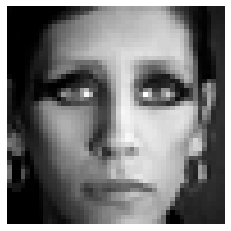

In [73]:
def show(img):
    img = img * 255
    # img = transform_train(img)[0]
    # print(img.shape)
    plt.axis("off")
    plt.imshow(img, cmap = 'gray')
    plt.show()

show(fer2013.pixels[4][0])

### Aumento il dataset
Facendo cambiamenti randomici come specchiatura e rotazione

In [13]:
transform_train = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomRotation(degrees=(-45,45))
])

### Definizione del modello

In [21]:
class Emotion_CNN(torch.nn.Module):
    def __init__(self):
        super(Emotion_CNN, self).__init__()
    
        self.num_imput_conv = 1
        self.num_filter_conv1 = 32
        self.num_filter_conv2 = 16

        self.cnn_layers = torch.nn.Sequential(
            # Defining a 2D convolution layer
            torch.nn.Conv2d(self.num_imput_conv, self.num_filter_conv1, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(self.num_filter_conv1),
            torch.nn.MaxPool2d(kernel_size=3, stride=1),
            # Defining another 2D convolution layer
            torch.nn.Conv2d(self.num_filter_conv1, self.num_filter_conv2, kernel_size=3, stride=1, padding=0),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(self.num_filter_conv2),
            torch.nn.MaxPool2d(kernel_size=3, stride=2),
            torch.nn.Softmax(dim=1),
        )
 
        self.linear_layers = torch.nn.Sequential(
            torch.nn.Linear(self.num_filter_conv2 * (21 * 21), 7)
        )
 
    # Defining the forward pass    
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

[Sito da cui ho preso il modello](https://www.analyticsvidhya.com/blog/2019/10/building-image-classification-models-cnn-pytorch/)

### Istanza del modello

Qua Lunni dobbiamo fare attenzione a `impostare il device in base all'ambiente` (Colab o locale)

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Emotion_CNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
criterion = torch.nn.CrossEntropyLoss()
device

device(type='cuda')

### Definizione di Training e Validation

In [23]:
train_losses = []
valid_losses = []

def Train():
    running_loss = .0
    model.train()

    for inputs,labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()

        #for i,img in enumerate(inputs):
            # show(inputs[i][0])
            # print(inputs[i][0].shape)
            # print(type(inputs[i][0]))
            # inputs[i][0] = transform_train(img[0].detach().cpu().data.numpy())
            # show(inputs[i][0])
            # print(inputs[i][0].shape)
            # print(type(inputs[i][0]))
        
        preds = model(inputs.float())
        loss = criterion(preds,labels)
        loss.backward()
        optimizer.step()
        running_loss += loss

    train_loss = running_loss/len(train_loader)
    train_losses.append(train_loss.detach().cpu().data.numpy())
    
    print(f'train_loss {train_loss}')
    
def Valid():
    running_loss = .0
    
    model.eval()
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            preds = model(inputs.float())
            loss = criterion(preds,labels)
            running_loss += loss
            
        valid_loss = running_loss/len(test_loader)
        valid_losses.append(valid_loss.detach().cpu().data.numpy())
        print(f'valid_loss {valid_loss}')

### Allenamento e Validazione del modello

In [24]:
epochs = 14

for epoch in range(epochs):
    print('epochs {}/{}'.format(epoch+1,epochs))
    Train()
    Valid()

epochs 1/14
train_loss 1.8184651136398315
valid_loss 1.7120676040649414
epochs 2/14
train_loss 1.6194016933441162
valid_loss 1.592437744140625
epochs 3/14
train_loss 1.5015743970870972
valid_loss 1.5238999128341675
epochs 4/14
train_loss 1.425253987312317
valid_loss 1.479350209236145
epochs 5/14
train_loss 1.369677186012268
valid_loss 1.4488487243652344
epochs 6/14
train_loss 1.3259966373443604
valid_loss 1.4267346858978271
epochs 7/14
train_loss 1.2899529933929443
valid_loss 1.4094752073287964
epochs 8/14
train_loss 1.2591016292572021
valid_loss 1.3959884643554688
epochs 9/14
train_loss 1.232006549835205
valid_loss 1.385178804397583
epochs 10/14
train_loss 1.2077873945236206
valid_loss 1.3763070106506348
epochs 11/14
train_loss 1.185882329940796
valid_loss 1.369005799293518
epochs 12/14
train_loss 1.1658766269683838
valid_loss 1.362962245941162
epochs 13/14
train_loss 1.1474647521972656
valid_loss 1.3580167293548584
epochs 14/14
train_loss 1.1303997039794922
valid_loss 1.3539602756500

### Visualizzazione grafico della loss

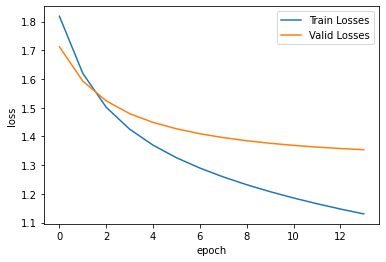

In [25]:
loss_df = pd.DataFrame( {'Train Losses':train_losses, 'Valid Losses':valid_losses }, index=list(range(len(train_losses))) )

loss_df=loss_df.astype(float)

xs = loss_df.plot()
_ = xs.set_ylabel("loss")
_ = xs.set_xlabel("epoch")

### Salva stato del modello

In [93]:
if IN_COLAB:
    torch.save(model.state_dict(), '/content/drive/My Drive/Università/Deep Learning/emotion-cnn/files/model_2021-12-08.pth')
else:
    torch.save(model.state_dict(), 'files/modello_ottimo.pth')

### Carica stato del modello

In [23]:
# model.load_state_dict(torch.load('files/saved_state_of_model.pth'))
model.load_state_dict(torch.load('files/modello_ottimo.pth', map_location=torch.device('cuda')))

<All keys matched successfully>

# Predizione e valutazione del modello

### Classificazione di Test

### Valutazione del modello

In [26]:
# Calculating the accuracy of the network on the whole dataset
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data # Getting the test data
        images, labels = images.cuda(), labels.cuda()
        outputs = model(images) # Getting the network output
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))


Accuracy of the network on the 10000 test images: 48 %


In [27]:
# Calculating the accuracy of the network on each class of images
class_correct = list(0. for i in range(7))
class_total = list(0. for i in range(7))

y = []
y_pred = []
with torch.no_grad():
    for data in test_loader:
        images, labels = data # Getting the test data
        images, labels = images.cuda(), labels.cuda()
        outputs = model(images) # Getting the network output
        _, predicted = torch.max(outputs, 1)

        y.extend(labels.squeeze().detach().cpu().numpy())
        y_pred.extend(predicted.squeeze().detach().cpu().numpy())
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

<AxesSubplot:>

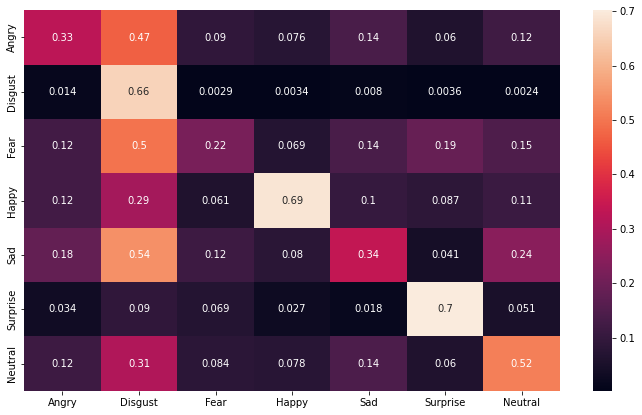

In [28]:
# Build confusion matrix
cf_matrix = confusion_matrix(y, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix, axis=1), index = [i for i in classes], columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)

In [61]:
print(classification_report(y, y_pred, digits=7))
metrics = classification_report(y, y_pred, digits=7, output_dict=True)

print("Accuratezza generale del modello:", f"{round(metrics['accuracy'], 3)}%")
print("Precisione media del modello:", f"{round(metrics['weighted avg']['precision'], 3)}%")
print("Recall media del modello:", f"{round(metrics['weighted avg']['recall'], 3)}%")
print("F1-Score medio del modello:", f"{round(metrics['weighted avg']['f1-score'], 3)}%")

              precision    recall  f1-score   support

           0  0.3525955 0.3757829 0.3638201       958
           1  0.2267081 0.6576577 0.3371824       111
           2  0.3428571 0.2580645 0.2944785      1023
           3  0.7203134 0.6739989 0.6963869      1773
           4  0.3886210 0.3231756 0.3528897      1247
           5  0.5920651 0.7003610 0.6416759       831
           6  0.4378613 0.4914842 0.4631257      1233

    accuracy                      0.4853679      7176
   macro avg  0.4372888 0.4972178 0.4499370      7176
weighted avg  0.4887555 0.4853679 0.4830313      7176

Accuratezza generale del modello: 0.485%
Precisione media del modello: 0.489%
Recall media del modello: 0.485%
F1-Score medio del modello: 0.483%
